In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import os
import random

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.math import confusion_matrix
import tensorflow as tf


In [16]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocessing
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocessing
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocessing
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocessing

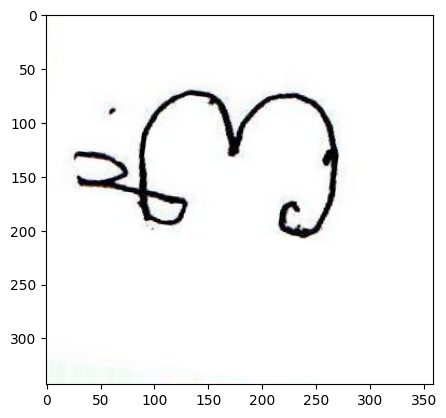

In [3]:
img = cv2.imread("/kaggle/input/tulu-handwritten-dataset/Tulu-Dtatset-V2/a/a_79.png")
plt.imshow(img)

In [4]:
img.shape

(343, 359, 3)

In [5]:
DATA_DIR="/kaggle/input/tulu-handwritten-dataset/Tulu-Dtatset-V2"
IMG_SHAPE=(128,128,3)

In [6]:
letters=os.listdir(DATA_DIR)
len(letters)

50

In [7]:
sample_image_paths = []

for i in letters:
    path = random.sample(glob(DATA_DIR+f"/{i}/"+"*.png"),k=1)
    sample_image_paths.append(str(path))

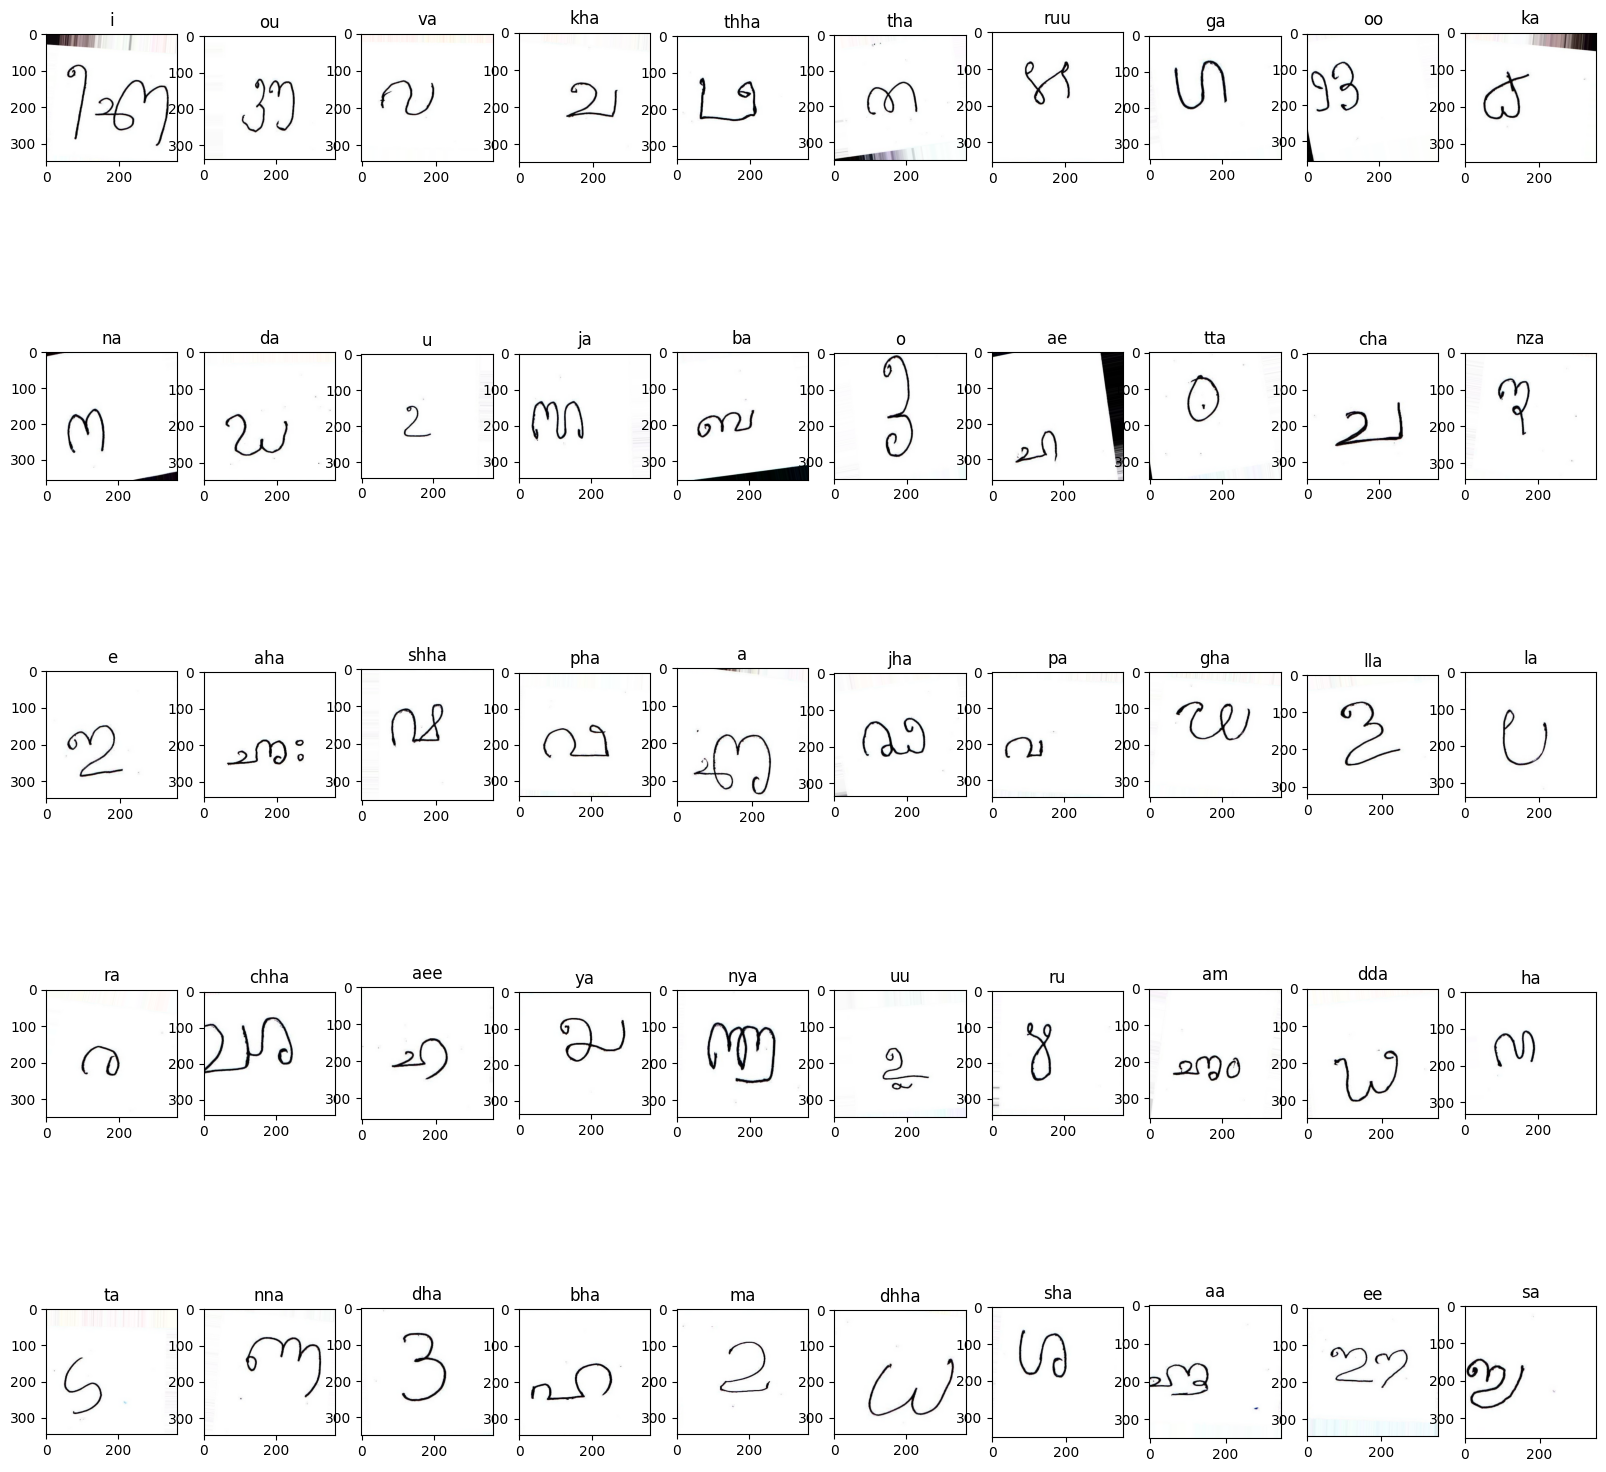

In [8]:
figs,axs=plt.subplots(5,10,figsize=(20,20))
idx=0

for col in range(10):
    for row in range(5):
        img_temp=cv2.imread(sample_image_paths[idx][2:-2])
        class_name=sample_image_paths[idx].split('/')[-2]
        axs[row,col].imshow(img_temp)
        axs[row,col].set_title(class_name)
        idx+=1

In [9]:
image_paths = []
class_labels = []

for i in letters:
    path = glob(os.path.join(DATA_DIR,i) + '/' + "*.png")
    image_paths.extend(path)
    class_labels.extend([i]*len(path))

In [10]:
df = pd.DataFrame(data={"Path":image_paths, "Label":class_labels})
df

,Path,Label
0,/kaggle/input/tulu-handwritten-dataset/Tulu-Dt...,i
1,/kaggle/input/tulu-handwritten-dataset/Tulu-Dt...,i
2,/kaggle/input/tulu-handwritten-dataset/Tulu-Dt...,i
3,/kaggle/input/tulu-handwritten-dataset/Tulu-Dt...,i
4,/kaggle/input/tulu-handwritten-dataset/Tulu-Dt...,i
...,...,...
4974,/kaggle/input/tulu-handwritten-dataset/Tulu-Dt...,sa
4975,/kaggle/input/tulu-handwritten-dataset/Tulu-Dt...,sa
4976,/kaggle/input/tulu-handwritten-dataset/Tulu-Dt...,sa
4977,/kaggle/input/tulu-handwritten-dataset/Tulu-Dt...,sa


In [11]:
df['Label'].value_counts()

Label
i       100
na      100
e       100
ra      100
ou      100
da      100
chha    100
aha     100
nna     100
u       100
ja      100
shha    100
aee     100
dha     100
pha     100
kha     100
thha    100
ya      100
nza     100
la      100
ba      100
tha     100
ma      100
uu      100
jha     100
o       100
ruu     100
ae      100
pa      100
dhha    100
ru      100
aa      100
gha     100
ga      100
ha      100
ka      100
ee      100
am      100
oo      100
cha     100
dda     100
lla     100
sa       99
ta       99
bha      99
tta      99
va       98
a        98
nya      98
sha      89
Name: count, dtype: int64

In [12]:
X=df
y=df[['Label']]

df_train,df_temp,y_train,y_temp=train_test_split(X,y,stratify=y,test_size=0.30,random_state=40)
df_val,df_test,y_val,y_test=train_test_split(df_temp,y_temp,stratify=y_temp,test_size=0.5,random_state=40)

In [17]:
train_efficientnet = ImageDataGenerator(preprocessing_function=efficientnet_preprocessing, horizontal_flip=True, vertical_flip=True)
val_efficientnet = ImageDataGenerator(preprocessing_function=efficientnet_preprocessing)
test_efficientnet = ImageDataGenerator(preprocessing_function=efficientnet_preprocessing)

eff_model = EfficientNetV2M(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
eff_model.trainable = False
eff_output = eff_model.output 

x = Flatten()(eff_output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
output = Dense(50, activation='softmax')(x)
eff_final_model = Model(eff_model.input, output)

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [18]:
BATCH_SIZE=32

reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=4,min_lr=0.0000001,verbose=1)
early_stopping=EarlyStopping(monitor='val_loss',patience=5,start_from_epoch=10)

In [19]:
LR=0.0003
eff_final_model.compile(optimizer='adam',
                       loss=CategoricalCrossentropy(),
                       metrics=['accuracy'])
train_generator = train_efficientnet.flow_from_dataframe(
    dataframe=df_train,
    directory='./',
    x_col="Path",
    y_col="Label",
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42,
)
valid_generator = train_efficientnet.flow_from_dataframe(
    dataframe=df_val,
    directory='./',
    x_col="Path",
    y_col="Label",
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42
)
test_generator = test_efficientnet.flow_from_dataframe(
    dataframe=df_test,
    directory='./',
    x_col="Path",
    y_col="Label",
    target_size=(128, 128),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
)

Found 3485 validated image filenames belonging to 50 classes.
Found 747 validated image filenames belonging to 50 classes.
Found 747 validated image filenames belonging to 50 classes.


In [20]:
history_efficientnet=eff_final_model.fit(train_generator,epochs=20,validation_data=valid_generator,callbacks=[reduce_lr,early_stopping],verbose=1)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/109 ━━━━━━━━━━━━━━━━━━━━ 3:58:53 133s/step - accuracy: 0.0312 - loss: 3.9073

I0000 00:00:1718371703.642491    2145 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718371703.792231    2145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 67/109 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - accuracy: 0.0219 - loss: 4.1122

W0000 00:00:1718371812.981435    2143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0253 - loss: 4.0566

W0000 00:00:1718371835.385577    2142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/109 ━━━━━━━━━━━━━━━━━━━━ 280s 1s/step - accuracy: 0.0254 - loss: 4.0555 - val_accuracy: 0.0884 - val_loss: 3.6556 - learning_rate: 0.0010
Epoch 2/20


W0000 00:00:1718371851.131407    2142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 163ms/step - accuracy: 0.1746 - loss: 2.9933 - val_accuracy: 0.3012 - val_loss: 2.4251 - learning_rate: 0.0010
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 163ms/step - accuracy: 0.2329 - loss: 2.7340 - val_accuracy: 0.3829 - val_loss: 2.1693 - learning_rate: 0.0010
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 169ms/step - accuracy: 0.2869 - loss: 2.4578 - val_accuracy: 0.4565 - val_loss: 1.8238 - learning_rate: 0.0010
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - accuracy: 0.3354 - loss: 2.1622 - val_accuracy: 0.5141 - val_loss: 1.6883 - learning_rate: 0.0010
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 162ms/step - accuracy: 0.3743 - loss: 2.0857 - val_accuracy: 0.5863 - val_loss: 1.4068 - learning_rate: 0.0010
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - accuracy: 0.4420 - loss: 1.8467 - val_accuracy: 0.6252 - val_loss: 1.2973 - learning_rate: 0.0010
Epoch 14/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 170ms/step - accuracy: 0.4611 - lo

In [22]:
train_inception = ImageDataGenerator(preprocessing_function=inception_preprocessing, horizontal_flip=True, vertical_flip=True)
val_inception = ImageDataGenerator(preprocessing_function=inception_preprocessing)
test_inception = ImageDataGenerator(preprocessing_function=inception_preprocessing)

In [24]:
inception_model =  InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
inception_model_output = inception_model.output

x = Flatten()(inception_model_output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
inception_output = Dense(50, activation='softmax')(x)
inception_final = Model(inception_model.input, inception_output)

In [25]:
LR = 0.0003
inception_final.compile(optimizer = 'adam',
            loss = CategoricalCrossentropy(),
            metrics=['accuracy'])

In [26]:
history_inception = inception_final.fit(train_generator, epochs=20, validation_data=valid_generator, callbacks=[early_stopping, reduce_lr])

Epoch 1/20
  1/109 ━━━━━━━━━━━━━━━━━━━━ 2:52:00 96s/step - accuracy: 0.0000e+00 - loss: 3.9492

W0000 00:00:1718372410.370360    2143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 38/109 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - accuracy: 0.0131 - loss: 4.0064  

W0000 00:00:1718372475.560590    2143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.0190 - loss: 3.9587

W0000 00:00:1718372492.066488    2145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/109 ━━━━━━━━━━━━━━━━━━━━ 188s 855ms/step - accuracy: 0.0190 - loss: 3.9582 - val_accuracy: 0.0201 - val_loss: 20327.3965 - learning_rate: 0.0010
Epoch 2/20


W0000 00:00:1718372502.809518    2143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 164ms/step - accuracy: 0.0476 - loss: 3.7405 - val_accuracy: 0.0201 - val_loss: 27583.3789 - learning_rate: 0.0010
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 169ms/step - accuracy: 0.0404 - loss: 3.5884 - val_accuracy: 0.0281 - val_loss: 14.3709 - learning_rate: 0.0010
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - accuracy: 0.0546 - loss: 3.4587 - val_accuracy: 0.0442 - val_loss: 5.4346 - learning_rate: 0.0010
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 162ms/step - accuracy: 0.0474 - loss: 3.3861 - val_accuracy: 0.0455 - val_loss: 20.1707 - learning_rate: 0.0010
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 167ms/step - accuracy: 0.0718 - loss: 3.2212 - val_accuracy: 0.0428 - val_loss: 4.2885 - learning_rate: 0.0010
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 167ms/step - accuracy: 0.0743 - loss: 3.1272 - val_accuracy: 0.0482 - val_loss: 202.3939 - learning_rate: 0.0010
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 161ms/step - accuracy: 0.0921